<a href="https://colab.research.google.com/github/YamenHabib/ML-DL/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvidia-smi

In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import math

from collections import Counter #subclass that remembers the order entries were added
import torchvision
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.optimizer import Optimizer
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.distributions import Categorical
from torch import jit
from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Dict, Any, Optional, Tuple, List, NamedTuple, Generator, cast

from IPython.display import Image as ipy_img
import matplotlib.pyplot as plt
import csv
from pathlib import Path
import pickle
import gc
from nltk.translate.bleu_score import sentence_bleu

pd.set_option('display.max_colwidth', None)

# torch.cuda.empty_cache()

use cuda if availabe.

In [ ]:
# on server I user both 1 and 2 and I used nn.DataParallel for training.
#device = torch.device("cuda:1,2" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #1,
# device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
# the path of our files.
DATA_PATH = '/content/drive/MyDrive/data/Flicker/'
# the path of the images that are contained in this file.
pres_imgs_path = '/content/drive/MyDrive/data/Flicker/Presentation Image/'
# read the catption dataset.
df = pd.read_csv(DATA_PATH + "captions.txt", sep=',')

First we need to preprocess our data:

1.   add "\<start>" and "\<end>" at the start and at the end of each caption.
2.   split captions to words.
3.   keep just words with alphabet letters (length >= 1) and convert them to lower case.
4.   add \"<pad>" at the end of captions shorter than the maximum length.
5.   vectorize words to tokens (indixes)
6.   build index_to_word and word_to_index dictionaries.



In [ ]:
def build_caption(caption):
    """Building our caption as list of tokens.

    add <start> and <end> at the end and the start of our captions,
    check that our tokens has alphabet letters and convert them to lower case.

    Args:
        caption (string): caption of an image.

    Returns:
        list of tokens from our input caption.
    """

    # isalpha() method returns True if all the characters are alphabet letters (a-z)
    return ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>']

# applied functon build_caption to each caption.
df['cleaned_caption'] = df['caption'].apply(build_caption)


def remove_empty(word_list):
    """ delete empty tokens

    keep tokens with length larger or equal 1.

    Args:
        word_list (list): list of tokens.

    Returns:
        lst (list): list of non empty tokens.
    """
    lst = []
    for word in word_list:
        if len(word)>=1:
            lst.append(word)
    return lst

df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_empty(x))

# get the maximum token length.
max_seq_len = df['cleaned_caption'].apply(lambda x : len(x)).max()
print(max_seq_len)

36


In [ ]:
# add pad token at the end of each token so they have the same length of max_seq_len
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda c:c + ['<pad>']*(max_seq_len-len(c)))

In [ ]:
# get all words.
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
# count the appearence of each word.
word_dict = Counter(word_list)
# sort the word from more appearnce to less.
word_dict = sorted(word_dict, key=word_dict.get, reverse=True)
# the number of our vocabulary.
vocab_size = len(word_dict)

In [ ]:
# build index_to_word and word_to_index dicts
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}

In [ ]:
# convert our captions to tokens.
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )
# sort the data frame according to the image. 
df = df.sort_values(by = 'image')

df.head(3)

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, a, child, in, a, pink, dress, is, climbing, up, a, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[2, 1, 42, 4, 1, 90, 169, 7, 119, 53, 1, 393, 12, 390, 4, 28, 5083, 691, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, a, girl, going, into, a, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[2, 1, 19, 312, 64, 1, 193, 117, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, a, little, girl, climbing, into, a, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[2, 1, 40, 19, 119, 64, 1, 193, 2404, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


split our dataset to 90% traingin and 10% validation.

In [ ]:
train = df.iloc[:int(0.9*len(df))]
unq_train_imgs = train[['image']].drop_duplicates()

valid = df.iloc[int(0.9*len(df)):]
unq_valid_imgs = valid[['image']].drop_duplicates()

In [ ]:
class imageDataset(Dataset):
    """
    A class used to represent our dataset.

    Attributes
    ----------
    data : Pandas Dataframe
        hold the name and the captions of our dataset.
    scaler : transforms.Resize
        to resize our images
    normalize : transforms.Normalize
        apply the Z-score normilization. 
    to_tensor : transforms.ToTensor
        convert our data to torch tensor.

    Methods
    -------
    __init__:
        define our Attributes
    __len__:
        return the lenth of the dataset.
    __getitem__:
        get an item using it's index.
    """
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name
        image_name = self.data.iloc[idx]['image']
        # define it's location
        img_loc = DATA_PATH + 'Images/'+str(image_name)
        # read the image
        img = Image.open(img_loc)
        # resize it then convert it to tensor then normilze the tensor.
        t_img = self.normalize(self.to_tensor(self.scaler(img)))
        # return image name and the the tensor of the image content.
        return image_name, t_img

### define the training and testing dataset to use them in extraxting the features aof the images.

In [ ]:
train_ImageDataset= imageDataset(unq_train_imgs)
train_ImageDataloader= DataLoader(train_ImageDataset, batch_size = 8, shuffle=False)

In [ ]:
valid_ImageDataset= imageDataset(unq_valid_imgs)
valid_ImageDataloader= DataLoader(valid_ImageDataset, batch_size = 8, shuffle=False)

### because we are goning to use the same encoder for our three decoder models, the clever thing to do is to get the feature vectors and save them on the disk, and then use them direclty. these will save us a lot of trainign time.

In [ ]:
def build_img_features():
    """ save image features on disk

    this function will use the forth layer of resnet34 to get the a 514 feature 
    vector of each image in our dataset.
    then it will save a results in two different files:
      - EncodedImageTrainResNet.pkl for traingin set.
      - EncodedImageValidResNet.pkl for validation set.

    """

    resnet34 = torchvision.models.resnet34(pretrained=True).to(device)
    resnet34.eval()
#     print(list(resnet34._modules))

    def get_vector(t_img):
        t_img = Variable(t_img)
        my_embedding = torch.zeros(1, 512, 7, 7)
        def copy_data(m, i, o):
            # print(o.data.shape)
            my_embedding.copy_(o.data)
        h = layer.register_forward_hook(copy_data)
        resnet34(t_img)
        h.remove()
        return my_embedding

    layer = resnet34._modules.get('layer4').to(device)

    # get training images features' vector
    imgsFeature_train = {}
    for image_name, t_img in tqdm(train_ImageDataloader):
        t_img = t_img.to(device)
        embdg = get_vector(t_img)
        imgsFeature_train[image_name[0]] = embdg

    # save training image features' vector.
    a_file = open(DATA_PATH + "EncodedImageTrainResNet.pkl", "wb")
    pickle.dump(imgsFeature_train, a_file)
    a_file.close()


    # get validation images features' vector
    imgsFeature_val = {}
    for image_name, t_img in tqdm(valid_ImageDataloader):
        t_img = t_img.to(device)
        embdg = get_vector(t_img)
        imgsFeature_val[image_name[0]] = embdg

    # save validation images features' vector.
    a_file = open(DATA_PATH + "EncodedImageValidResNet.pkl", "wb")
    pickle.dump(imgsFeature_val, a_file)
    a_file.close()


In [ ]:
# build_img_features()

In [ ]:
class EncodedImageDataset(Dataset):
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get caption tokens indices of the image.
        caption_seq = self.data.iloc[idx]['text_seq']
        # the target will be the same caption with one shift to the right.
        target_seq = caption_seq[1:]+[0]
        # get the image name.
        image_name = self.data.iloc[idx]['image']
        # get the encoded image file. (feature vector)
        image_tensor = self.encodedImgs[image_name]
        # permutate
        image_tensor = image_tensor.permute(0,2,3,1)
        # flatten the tensor
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
        # return the input and target caption and the image name.
        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view, image_name

In [ ]:
train_encodedDataset = EncodedImageDataset(train, DATA_PATH + 'EncodedImageTrainResNet.pkl')
train_encodedDataloader = DataLoader(train_encodedDataset, batch_size = 8, shuffle=True)

In [ ]:
valid_encodedDataset = EncodedImageDataset(valid, DATA_PATH + 'EncodedImageValidResNet.pkl')
valid_encodedDataloader = DataLoader(valid_encodedDataset, batch_size = 8, shuffle=True)

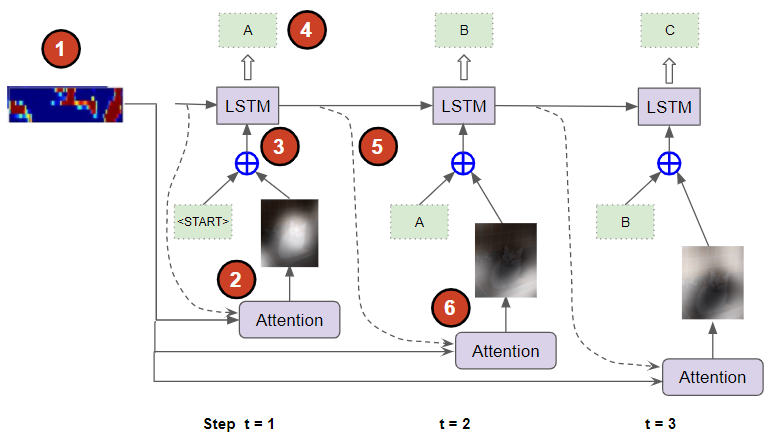

In [ ]:
ipy_img(filename=pres_imgs_path+'lstm.png', width=700, height=500)

Suppose that
there are $T$ tokens in the input sequence,
the context variable at the decoding time step $t'$
is the output of attention pooling:

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

where the decoder hidden state $\mathbf{s}_{t' - 1}$ at time step $t' - 1$ is the query, and the encoder output (image feature) $\mathbf{h}_t$ are both the keys and values,and the attention weight $\alpha$ is computed using the additive attention scoring function is as follow:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$

In general, when queries and keys are vectors of different lengths, we can use **additive attention** as the scoring function.
Given a query $\mathbf{q} \in \mathbb{R}^q$ and a key $\mathbf{k} \in \mathbb{R}^k$, the *additive attention* scoring function

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

where
learnable parameters
$\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$, and $\mathbf w_v\in\mathbb R^{h}$.
Equivalent to
the query and the key are concatenated
and fed into an MLP with a single hidden layer
whose number of hidden units is $h$, a hyperparameter.
By using $\tanh$ as the activation function and disabling bias terms.


In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.Q = nn.Linear(decoder_dim,attention_dim)
        self.K = nn.Linear(encoder_dim,attention_dim)
        self.V = nn.Linear(attention_dim,1)

    def forward(self, features, hidden_state):
        k_hs = self.K(features)                                   #(batch_size,num_layers,attention_dim)
        q_ah = self.Q(hidden_state)                               #(batch_size,attention_dim)
        combined_states = torch.tanh(k_hs + q_ah.unsqueeze(1))    #(batch_size,num_layers,attemtion_dim)
        attention_scores = self.V(combined_states)                #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)            #(batch_size,num_layers)
        alpha = F.softmax(attention_scores,dim=1)                 #(batch_size,num_layers)
        attention_weights = features * alpha.unsqueeze(2)         #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)          #(batch_size,num_layers)
        return alpha, attention_weights

In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    def forward(self, features, captions):
        #vectorize the caption
        embeds = self.embedding(captions)
        # Initialize LSTM state with the mean value of the encoder
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        #get the seq length to iterate
        seq_length = len(captions[0]) #Exclude the last one -1
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)

        for s in range(seq_length):
            # get the attention results of the deatures.
            alpha, context = self.attention(features, h)
            # concatinate the emdedding of the word input s and the context vector.
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            # get the hidden and cell state vectors.
            h, c = self.lstm_cell(lstm_input, (h, c))
            # get the output 
            output = self.fcn(self.drop(h))
            # save
            preds[:,s] = output
            alphas[:,s] = alpha

        return preds, alphas

    def generate_caption(self,features,max_len=max_seq_len):
        # Inference part
        # Given the image features generate the captions
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        alphas = []
        #starting input
        word = torch.tensor(word_to_index['start']).view(1,-1).to(device)
        embeds = self.embedding(word)
        captions = []
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            #save the generated word
            captions.append(predicted_word_idx.item())
            #end if <<end> detected>
            if index_to_word[predicted_word_idx.item()] == "<end>":
                break
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        #covert the vocab idx to words and return sentence
        return [index_to_word[idx] for idx in captions[:-1]],alphas

    def init_hidden_state(self, encoder_out):
        # initialize with the maen value of the encoder.
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class Model(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, features, captions):
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
#Hyperparams
embed_size=300
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

#init model
model = Model(embed_size=300, vocab_size = vocab_size, attention_dim=256, 
              encoder_dim=512, decoder_dim=512).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<pad>"])
optimizer = Adam(model.parameters(), lr=learning_rate)

EPOCHS= 30
min_val_loss = float('inf')

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = 0
    for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(train_encodedDataloader, desc=f'Epoch {epoch}')):
        caption_seq, target_seq, image_embed = caption_seq.to(device), target_seq.to(device), image_embed.to(device)
        image_embed = image_embed[:, 0, :, :]
        # Zero the gradients.
        optimizer.zero_grad()
        # Feed forward
        outputs, attentions = model(image_embed, caption_seq)
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), target_seq.reshape(-1))
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
        train_epoch_loss += loss.detach().item()

    train_epoch_loss /= len(train_encodedDataloader)
    val_epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(valid_encodedDataloader, desc=f'Epoch {epoch}')):
            caption_seq, target_seq, image_embed = caption_seq.to(device), target_seq.to(device), image_embed.to(device)
            image_embed = image_embed[:, 0, :, :]
            # Zero the gradients.
            optimizer.zero_grad()
            # Feed forward
            outputs, attentions = model(image_embed, caption_seq)
            # Calculate the batch loss.
            loss = criterion(outputs.view(-1, vocab_size), target_seq.reshape(-1))
            # add loss
            val_epoch_loss += loss.detach().item()
    val_epoch_loss /= len(valid_encodedDataloader)
    print(f'Epoch: {epoch}, Train Loss: {train_epoch_loss}, Validation Loss: {val_epoch_loss}')
    if min_val_loss > val_epoch_loss:
        print(f"Update Model at Epoch :{epoch}")
        torch.save({'state_dict': model.state_dict()}, DATA_PATH + 'lstm_model.tar')
        min_val_loss = val_epoch_loss

Epoch 0:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 3.770561202443966, Validation Loss: 3.2797867040860322
Update Model at Epoch :0


Epoch 1:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 3.09316717347487, Validation Loss: 3.088936067381395
Update Model at Epoch :1


Epoch 2:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 2.826367241636521, Validation Loss: 3.0314569781891443
Update Model at Epoch :2


Epoch 3:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 2.627213587738927, Validation Loss: 3.0088965190729136
Update Model at Epoch :3


Epoch 4:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 2.4608790680163772, Validation Loss: 3.0262727975374153


Epoch 5:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 2.324230255162988, Validation Loss: 3.0152881107782656


Epoch 6:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 2.1915444555464862, Validation Loss: 3.023081271073564


Epoch 7:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 2.078176842108762, Validation Loss: 3.0392068881291174


Epoch 8:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.9697767080238289, Validation Loss: 3.073292444817162


Epoch 9:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 1.872513563593159, Validation Loss: 3.110840544634657


Epoch 10:   0%|          | 0/4552 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model = Model(embed_size=300, vocab_size = vocab_size, attention_dim=256, encoder_dim=512, decoder_dim=512)
checkpoint = torch.load(DATA_PATH + 'lstm_model.tar')
model.load_state_dict(checkpoint['state_dict'])
model= model.to(device)

In [ ]:
#generate caption
def get_caps_from(features):
    #generate the caption
    model.eval()
    with torch.no_grad():
        caps,alphas = model.decoder.generate_caption(features)
        caption = ' '.join(caps)
    return caption

a dog is running on the grass


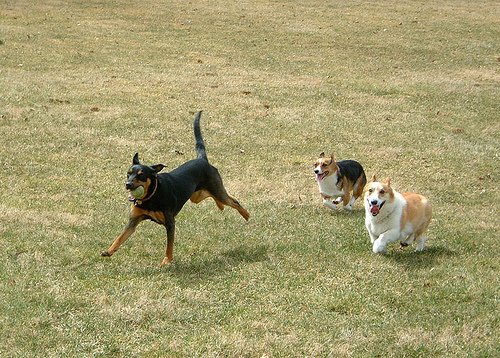

In [ ]:
img_index = 78
_,_, img, img_name = valid_encodedDataset[img_index]
print(get_caps_from(img.to(device)))
Image.open(DATA_PATH +'Images/' +img_name)

# BLEU (Bilingual Evaluation Understudy)

BLEU is a modification of accuracy metric, which is reweighted in a way to avoid returning highest scores for the one-word results:

$$\text{BLEU}=\text{BP}\cdot\exp\bigg(\sum_{i=1}^m w_i \log p_i\bigg)
$$
where
$$\text{BP}=
\left\{ \begin{array}{ll}
		1, & \text{if } c>r;\\
		\exp(1-r/c), & \text{otherwise}.
\end{array}\right.$$

where $r$ - is a length of a right answer, $c$ - length of model answer, $p_i$ - precision, $w_i$ - weights summing up to 1.

In [ ]:
blue_1, blue_2, blue_3, blue_4 = 0, 0, 0, 0
with torch.no_grad():
    for (_, _, image_embed, img_name) in valid_encodedDataset:
        references_corpus = list(df[df['image'] == img_name]['caption'])
        references_corpus = [x.split(' ') for x in references_corpus]
        candidate_corpus = [get_caps_from(image_embed.to(device))]
        candidate_corpus = [x.split(' ') for x in candidate_corpus][0]
        blue_1 += sentence_bleu(references_corpus, candidate_corpus, weights=(1, 0, 0, 0))
        blue_2 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.5, 0.5, 0, 0))
        blue_3 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.33, 0.33, 0.33, 0))
        blue_4 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.25, 0.25, 0.25, 0.25))

    blue_1 /= len(valid_encodedDataset)
    blue_2 /= len(valid_encodedDataset)
    blue_3 /= len(valid_encodedDataset)
    blue_4 /= len(valid_encodedDataset)

In [ ]:
blue_1, blue_2, blue_3, blue_4

(0.5209154625048006,
 0.32062841576172596,
 0.15373603110667797,
 0.057789861744985425)

# [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

paper: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure.
Here, the encoder maps an input sequence of symbol representations $(x_1,...,x_n)$ to a sequence of continuous representations $z = (z_1,...,z_n)$.
Given $z$, the decoder then generates an output sequence $(y_1, ..., y_m)$ of symbols one element at a time.
At each step the model is **auto-regressive**, consuming the previously generated symbols as additional input when generating the next.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence
in order to compute a representation of the sequence.


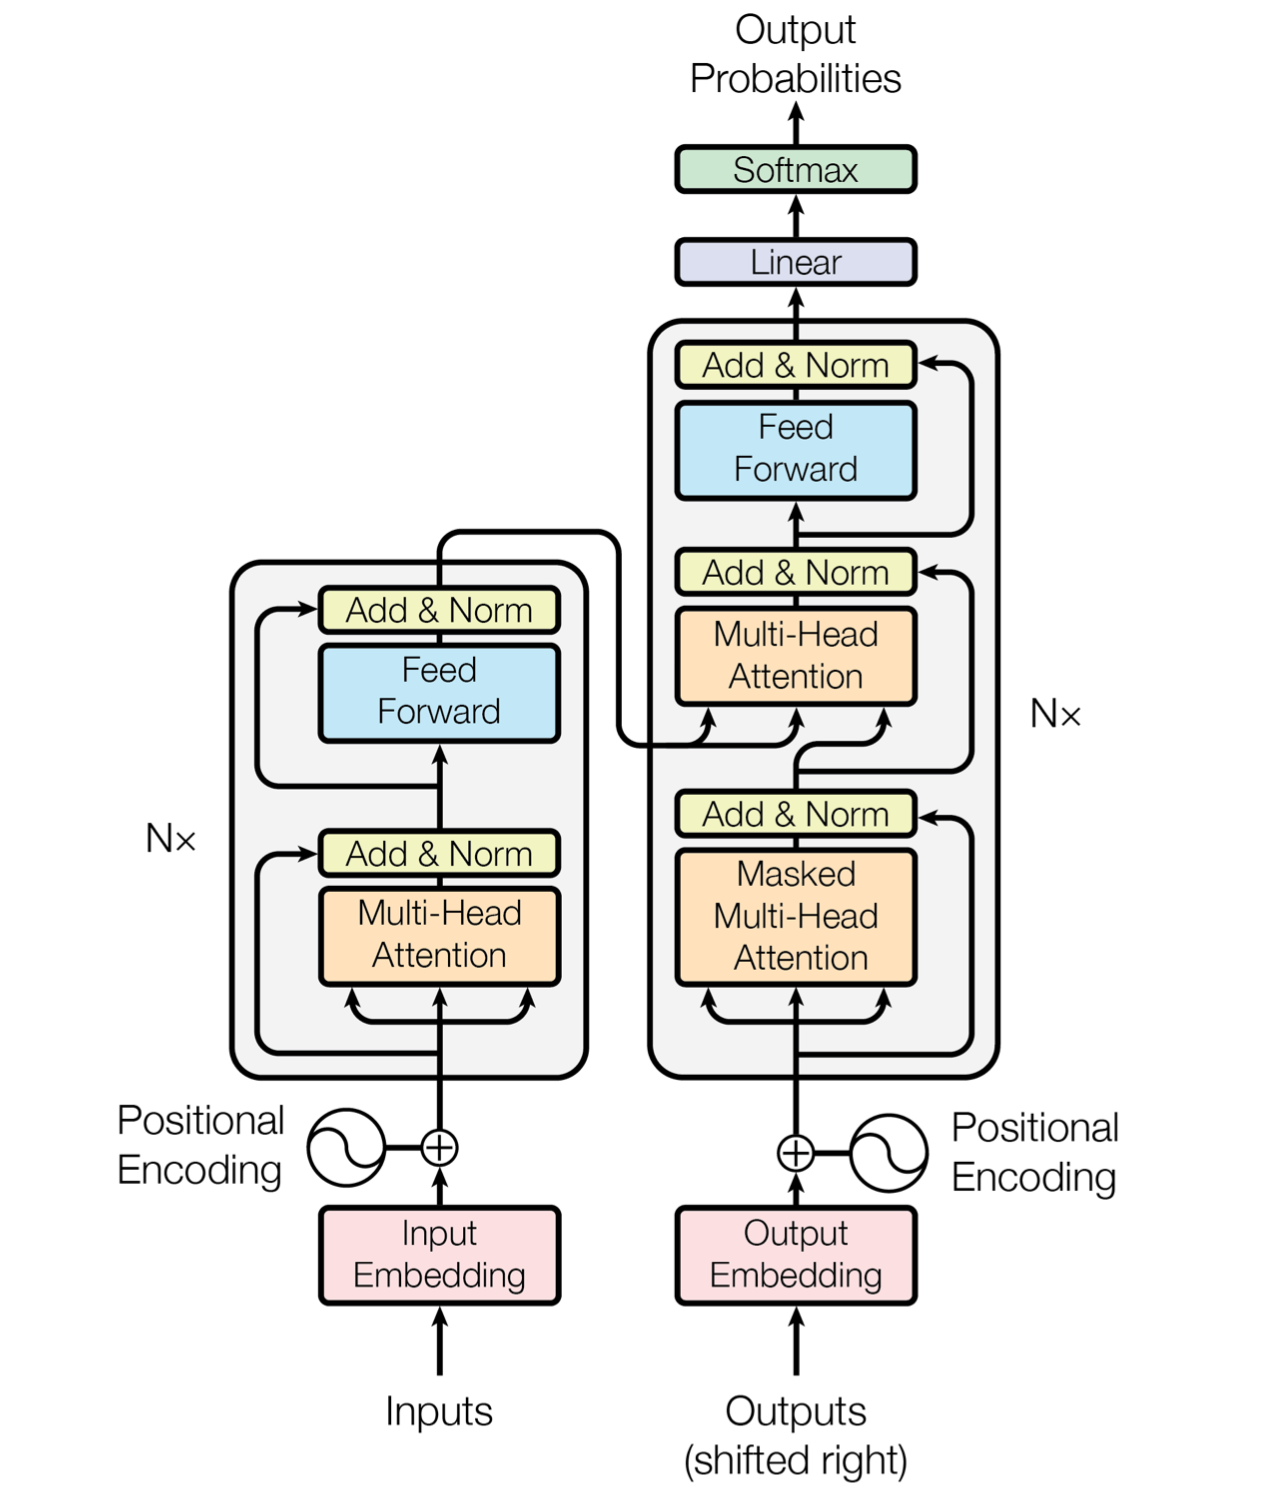

In [ ]:
ipy_img(filename=pres_imgs_path+'/transformer.png', width=500, height=500)


# Decoder

The decoder is composed of a stack of N = 6 identical layers.

Each Layer has the two sub-layers Multi-Head Attention and Position-wise feed forward, the decoder also inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.

we employ residual connections around each of the sub-layers, followed by layer normalization.

the self-attention sub-layer in the decoder stack is built to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.


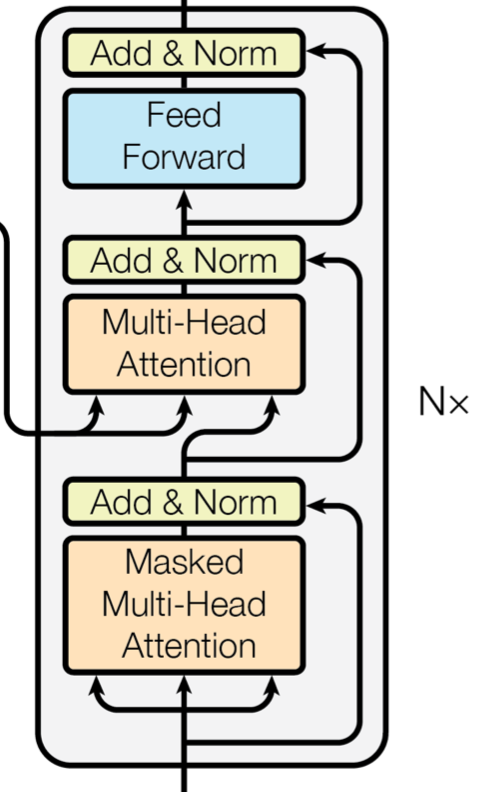

In [ ]:
ipy_img(filename=pres_imgs_path+'/decoder.png', width=300, height=400)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, num_layers):
        super(Decoder, self).__init__()
        self.layers = get_clones(layer, num_layers)
        self.norm = nn.LayerNorm(layer.d_model)

    def forward(self, x, memory, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return self.norm(x)

We employ a **residual connection** around each of the two sub-layers, followed by **layer normalization**.

That is, the output of each sub-layer is $\color{blue}{\textrm{LayerNorm}(x + \textrm{Sublayer}(x))}$, where $\textrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension `d_model` = 512.



In [ ]:
class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout):
        super(ResidualConnection, self).__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, layer):
        return x + self.dropout(layer(self.norm(x)))

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.layer = get_clones(ResidualConnection(d_model, dropout), 3)

    def forward(self, x, memory, tgt_mask):
        m = memory
        x = self.layer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.layer[1](x, lambda x: self.src_attn(x, m, m))
        return self.layer[2](x, self.feed_forward)

# Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.

The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function
of the query with the corresponding key.

# Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention". The input consists of **queries** and **keys** of dimension $d_k$, and **values** of dimension $d_v$.

We compute the dot products of the **query** with **all keys**, divide each by $\sqrt{d_k}$, and apply a **softmax** function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries **simultaneously**, packed together into a matrix $Q$.

The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:

$$\textrm{Attention}\big(Q,K,V\big)=\textrm{softmax}\bigg(\frac{QK^T}{\sqrt{d_k}}\bigg)V$$

The two most commonly used attention functions are **additive attention**, and dot-product (**multiplicative**) attention.

Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$.

**Additive attention** computes the compatibility function using a feed-forward network with a single hidden layer.

$$\alpha(k,q)=\mathbf{v}^T\tanh\big(W_kk+W_qq\big), \;W_k\in\mathbb{R}^{h\times d_k},\; W_q\in\mathbb{R}^{h\times d_q},\; \mathbf{v}\in\mathbb{R}^{d_v}$$

While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice,
since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms
dot product attention without scaling for larger values of $d_k$. We suspect that for large values of $d_k$,
the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients .

To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

To illustrated why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean 0 and variance 1.

Then their dot product $\displaystyle q\cdot k=\sum_{i=1}^{d_k}q_ik_i$ has mean 0 and variance $d_k$.



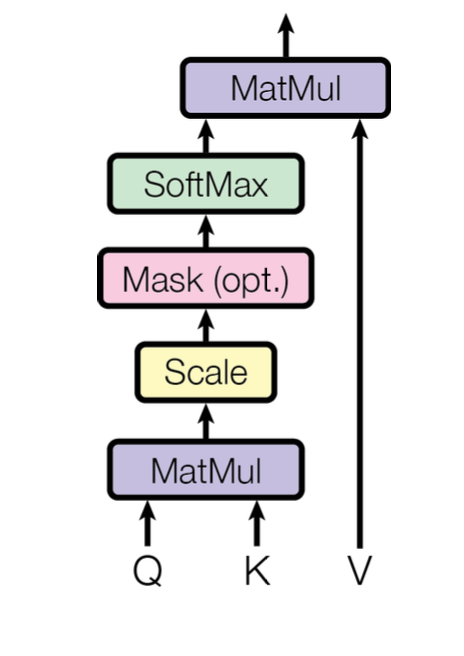

In [ ]:
ipy_img(filename=pres_imgs_path + '/scaled_dot_product_attention.png', width=300, height=350)

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
def generate_square_subsequent_mask(size, inp):
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    if inp is not None:
        pad_mask = inp.float().masked_fill(inp == 0, float(0.0)).masked_fill(inp > 0, float(1.0))
        return mask, pad_mask
    else:
        return mask

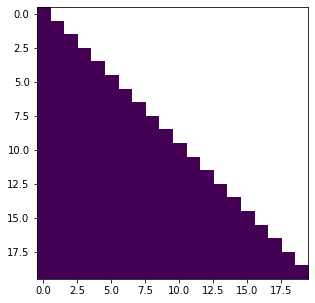

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(generate_square_subsequent_mask(20, None));

# Multi-Head Attention

Instead of performing a single attention function with $d_{\textrm{model}}$-dimensional keys, values and queries, we found it beneficial
to **linearly project** the queries, keys and values h times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.

On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values.

These are concatenated and once again projected, resulting in the final values, as depicted in the picture below.

ipy_img(filename='Images/multi_head_attention.png', width=300, height=350)

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = get_clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(0)
        nbatches = query.size(0)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Multi-head attention allows the model to **jointly attend** to information from **different representation subspaces at different positions**.

With a single attention head, averaging inhibits this.

$$\textrm{MultiHead}\big(Q,K,V\big)=\textrm{Concat}\big(\textrm{head}_1,\ldots,\textrm{head}_h\big)W^O$$

where

$$\textrm{head}_i=\textrm{Attention}\big(QW_i^Q,KW_i^K,VW_i^V\big)$$

Where the projections are parameter matrices $W_i^Q\in\mathbb{R}^{d_{\textrm{model}}\times d_k}$, $W_i^K\in\mathbb{R}^{d_{\textrm{model}}\times d_k}$, $W_i^V\in\mathbb{R}^{d_{\textrm{model}}\times d_v}$ and $W^O\in \mathbb{R}^{hd_v \times d_{\textrm{model}}}$.

In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k = d_v = d_{\textrm{model}}/h = 64$.

Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

# Applications of Attention in the Our Transformer Model

Our Transformer uses multi-head attention in two different ways:

1) In **encoder-decoder attention** layers, the **queries** come from the **previous decoder layer**, and the **memory keys** and **values** come from the **output of the encoder** (Images' Features).

This allows every position in the decoder to attend over all information withing feature image.

This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models.

3) Similarly, **self-attention** layers in the **decoder** allow each position in the decoder to attend to all positions in the decoder up to and including that position.

We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.

We implement this inside of scaled dot- product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.



# Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.

This consists of two linear transformations with a ReLU activation in between.

$$\textrm{FFN}(x)=\max\big(0, xW_1+b_1\big)W_2+b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer.
Another way of describing this is as two **convolutions with kernel size 1**.

The dimensionality of input and output is $d_{\textrm{model}} = 512$, and the inner-layer has dimensionality $d_{ff} = 2048$.

ipy_img(filename='Images/ffn.png', width=300, height=350)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# Embeddings and Softmax

Similarly to other sequence transduction models, we use **learned embeddings** to convert the input tokens and output tokens to vectors of dimension $d_{\textrm{model}}$.

We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.

In our model, we **share the same weight matrix** between the two embedding layers and the pre-softmax and linear transformation.

In the embedding layers, we multiply those weights by $\sqrt{d_{\textrm{model}}}$.

# Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the **order of the sequence**,
we must inject some information about the relative or absolute position of the tokens in the sequence.

To this end, we add “positional encodings” to the input embeddings at the bottoms of decoder stacks.
The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.

There are many choices of positional encodings, learned and fixed.

In [Attention Is All You Need](https://arxiv.org/abs/1706.03762), they use sine and cosine functions of different frequencies:

$$\textrm{PE}_{(pos, 2i)}=\sin\big(pos/10000^{2i/d_{\text{model}}}\big)\\
\textrm{PE}_{(pos, 2i+1)}=\cos\big(pos/10000^{2i/d_{\text{model}}}\big)$$

where $pos$ is the position and $i$ is the dimension.

That is, each dimension of the positional encoding corresponds to a sinusoid.

The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.

They chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$
can be represented as a linear function of $PE_{pos}$.

In addition, They apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.
For the base model, we use a rate of $P_{drop}=0.1$.

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pos_enc = torch.zeros((1, max_len, d_model))
        periods = torch.pow(10000, -2 * torch.arange(d_model // 2 + 1, dtype=torch.float) / d_model)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        pos_enc[0, :, 0::2] = torch.sin(periods[:(d_model + 1) // 2] * positions)
        pos_enc[0, :, 1::2] = torch.cos(periods[:d_model // 2] * positions)

        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[:, :x.size(1), :]
        return self.dropout(x)

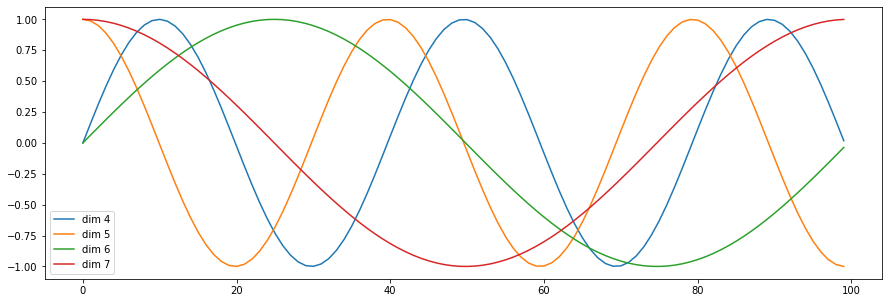

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]]);

In [ ]:
def get_clones(module, n):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

In [ ]:
class LMHead(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(LMHead, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

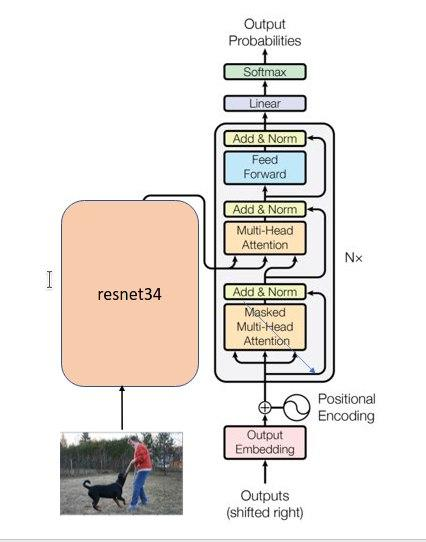

In [ ]:
ipy_img(filename=pres_imgs_path+'model.jpg')

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size: int,
                 nhead = 8, num_decoder_layers = 8,
                 d_model = 512,  dim_feedforward = 512,
                dropout= 0.2):

        super(Model, self).__init__()
        c = copy.deepcopy
        attn = MultiHeadedAttention(nhead, d_model)
        ff = PositionwiseFeedForward(d_model, dim_feedforward, dropout)
        emb = nn.Embedding(vocab_size, d_model)
        pos_enc = PositionalEncoding(d_model, dropout)

        self.decoder_layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
        self.decoder = Decoder(self.decoder_layer, num_decoder_layers)

        self.tgt_embed = tgt_embed = nn.Sequential(c(emb), c(pos_enc))
        self.generator = LMHead(d_model, vocab_size)
        self._reset_parameters()
        self.d_model = d_model
        self.nhead = nhead
        self.dummy_param = nn.Parameter(torch.empty(0))

    @property
    def device(self) -> torch.device:
        return self.model.generator.linear.weight.device

    def forward(self, encoded_image, caption_seq): #caption_mask
        caption_mask, pad_mask = generate_square_subsequent_mask(caption_seq.shape[1], caption_seq)
        pad_mask = pad_mask.to(self.dummy_param.device)
        caption_mask = caption_mask.to(self.dummy_param.device)
        out = self.decoder(self.tgt_embed(caption_seq), encoded_image, caption_mask)
        return out, pad_mask

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

#     def start_generation(self, src: Tensor):
#         initial = GenerationState(self, src)
#         return initial.next(self.start_code)

In [ ]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [ ]:
def setup_optimizer(module: nn.Module):
    optimizer = NoamOpt(512, 2, 4000, torch.optim.Adam(module.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    return optimizer

In [ ]:
try:
    del model
except:
    pass

# Cross-Entropy Loss

We usually write cross-entropy loss function in the next form

$$\displaystyle \mathcal{L}(y, \hat{y})=-\sum_{i=1}^m\sum_{\ell=1}^k y^{(i)}_{\ell}\log \hat{y}_{\ell}^{(i)}$$

where $\hat{y}$ is the output of the decoder's softmax.

Let us recall, that we are actually dealing with two probability distributions and cross-entropy can be written like that

$$\displaystyle \mathcal{L}(p, q_{\theta})=-\sum_{i=1}^m\sum_{\ell=1}^k p\big(y\;|\; x^{(i)}\big) \log q_{\theta}\big(y \;|\; x^{(i)}\big)$$

where for a particular example

$$H_i(p,q_{\theta})=-\sum_{\ell=1}^k p\big(y\;|\; x^{(i)}\big) \log q_{\theta}\big(y \;|\; x^{(i)}\big)$$

# BLEU (Bilingual Evaluation Understudy)

BLEU is a modification of accuracy metric, which is reweighted in a way to avoid returning highest scores for the one-word results:

$$\text{BLEU}=\text{BP}\cdot\exp\bigg(\sum_{i=1}^m w_i \log p_i\bigg)
$$
where
$$\text{BP}=
\left\{ \begin{array}{ll}
		1, & \text{if } c>r;\\
		\exp(1-r/c), & \text{otherwise}.
\end{array}\right.$$

where $r$ - is a length of a right answer, $c$ - length of model answer, $p_i$ - precision, $w_i$ - weights summing up to 1.


# Raw Model Training and Inferencing


In [ ]:
model = Model(vocab_size) #
# model = nn.DataParallel(Model(vocab_size) ,device_ids = [2]) #1,
model = model.to(device)
optimizer = setup_optimizer(model)
EPOCHS = 8
criterion = torch.nn.CrossEntropyLoss()
min_val_loss = float('Inf')

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = 0
    for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(train_encodedDataloader, desc=f'Epoch {epoch}')):
        optimizer.optimizer.zero_grad()
        # move tensors to device
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)
        image_embed = image_embed.to(device)

        scores, pad_mask = model(image_embed, caption_seq) #caption_mask
        output = model.generator(scores) #model.module.generator(scores)
        output = output.permute(0, 2, 1)
        target_seq = target_seq.to(output.device)

        loss = criterion(output, target_seq)
        # caculate the sum of the cost function of the main words without the padding words.
        loss_masked = torch.mul(loss, pad_mask)
        # calculate the loss function
        batch_loss = torch.sum(loss_masked)/torch.sum(pad_mask)
        # backward
        batch_loss.backward()
        optimizer.step()
        train_epoch_loss += torch.sum(loss_masked).detach().item()
    train_epoch_loss /= len(train_encodedDataloader)

    val_epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_no, (caption_seq, target_seq, image_embed, _) in enumerate(tqdm(valid_encodedDataloader, desc=f'Epoch {epoch}')):
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)
            image_embed = image_embed.to(device)
            scores, pad_mask = model(image_embed, caption_seq) #caption_mask
            output = model.generator(scores) #model.module.generator(scores)
            output = output.permute(0, 2, 1)
            target_seq = target_seq.to(output.device)

            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, pad_mask)
            batch_loss = torch.sum(loss_masked)/torch.sum(pad_mask)

            val_epoch_loss += torch.sum(loss_masked).detach().item()

    val_epoch_loss /= len(valid_encodedDataloader)

    print(f'Epoch: {epoch}, Train Loss: {train_epoch_loss}, Validation Loss: {val_epoch_loss}')
    if min_val_loss > val_epoch_loss:
        print(f"Update Model at Epoch :{epoch}")
        torch.save({'state_dict': model.state_dict()}, 'model.tar')
        min_val_loss = val_epoch_loss

Epoch 0:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 117.83791776407372, Validation Loss: 55.96812567880502
Update Model at Epoch :0


Epoch 1:   0%|          | 0/4552 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 46.634554159819345, Validation Loss: 32.14979222734926
Update Model at Epoch :1


Epoch 2:   0%|          | 0/4552 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model = nn.DataParallel(Model(vocab_size) ,device_ids = [2]) #1,
checkpoint = torch.load('model.tar')
model.load_state_dict(checkpoint['state_dict'])

valid_img_embed = pd.read_pickle( DATA_PATH + 'EncodedImageValidResNet.pkl')

In [ ]:
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

In [ ]:
def generate_caption(K, img_nm):
    img_loc = 'Flicker/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())

    img_embed = valid_img_embed[img_nm].to(device)
    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    model.eval()
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len-1):

            scores, padding_mask = model.forward(img_embed, input_seq)
            output = model.module.generator(scores)
            output = output[0, eval_iter, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]
            next_word = index_to_word[next_word_index]
            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

In [ ]:
# generate_caption(1, unq_valid_imgs.iloc[50]['image'])

# based on Pytorch Implementation

In [ ]:
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
print(start_token, end_token, pad_token)

2 3 0


In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        # define a decodel layer
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model = embedding_size, nhead= n_head)
        # build a stack of decoder layers.
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer= self.TransformerDecoderLayer, num_layers= n_decoder_layer)
        self.embedding_size = embedding_size
        # embedding layer
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        # the generator layer.
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, tgt):
        tgt_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
        pad_mask = tgt.float().masked_fill(tgt == 0, float(0.0)).masked_fill(tgt > 0, float(1.0))
        pad_mask_bool = tgt == 0
        return tgt_mask.to(device), pad_mask.to(device), pad_mask_bool.to(device)

    def forward(self, encoded_image, tgt):
        # get the embedding
        tgt_embed = self.pos_encoder(self.embedding(tgt)* math.sqrt(self.embedding_size))

        tgt_embed = tgt_embed.permute(1,0,2)
        encoded_image = encoded_image.permute(1,0,2)
        tgt_mask, pad_mask, pad_mask_bool = self.generate_Mask(tgt.size(1), tgt)

        decoder_output = self.TransformerDecoder(tgt = tgt_embed,
                                                 memory = encoded_image,
                                                 tgt_mask = tgt_mask,
                                                 tgt_key_padding_mask = pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)
        return final_output,  pad_mask

In [ ]:
EPOCH = 30
model = ImageCaptionModel(8, 8, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

In [ ]:
for epoch in range(EPOCH):
    epoch_train_loss, epoch_valid_loss = 0, 0
    train_words, valid_words  = 0, 0
    model.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed, _ in tqdm(train_encodedDataloader):
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = model.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)
        loss = criterion(output,target_seq)
        loss_masked = torch.mul(loss, padding_mask)
        batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += torch.sum(loss_masked).detach().item()
        train_words += torch.sum(padding_mask)

    epoch_train_loss = epoch_train_loss/train_words

    ### Eval Loop
    model.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed, _ in tqdm(valid_encodedDataloader):
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)
            output, padding_mask = model.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)
            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)
            epoch_valid_loss += torch.sum(loss_masked).detach().item()
            valid_words += torch.sum(padding_mask)

    epoch_valid_loss = epoch_valid_loss/valid_words

    print("Epoch -> ", epoch," Training Loss -> ", epoch_train_loss.item(),
          "Eval Loss -> ", epoch_valid_loss.item() )

    if min_val_loss > epoch_valid_loss:
        print("Updating Model at epoch ", epoch)
        torch.save(model, DATA_PATH + 'model.tar')
        min_val_loss = epoch_valid_loss
    scheduler.step(total_epoch_valid_loss.item())

In [ ]:
valid_img_embed = pd.read_pickle(DATA_PATH +'EncodedImageValidResNet.pkl')

model = torch.load(DATA_PATH + 'pyorch_im_model.tar', map_location= device)
max_seq_len = 36

In [ ]:
def generate_caption(K, img_nm):
    img_loc = DATA_PATH + 'Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['A black dog and a woman in a red shirt playing tug of war .', 'A dog is pulling on one end of a rope and a girl is pulling on the other .', 'A woman plays tug-of-war with her black dog in a brown landscape surrounded by trees .', 'A woman plays with her rottweiler dog outside .', 'A woman and a dog playing outside']


Predicted caption : 
a man with a black and brown dog is standing on grass .


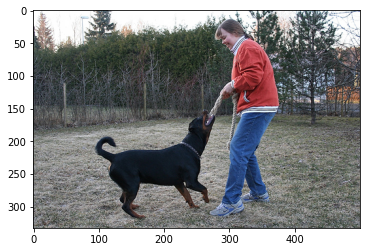

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[80]['image'])

Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
a person is climbing a mountain .


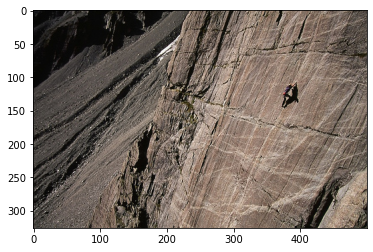

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[100]['image'])

Actual Caption : 
['A black man with a red mask is carrying a box .', 'A man in a domino mask carries an amplifier up a hill .', 'A man with a mask carrying a black speaker', 'A masked man in bright clothing carrying a large box .', 'Black man lifting black box is watched by black dog .']


Predicted caption : 
a man and a dog are standing in a grassy area .


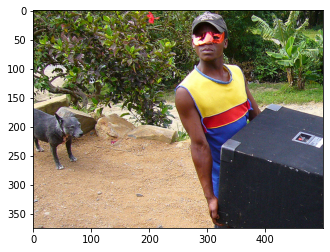

In [ ]:
generate_caption(1, unq_valid_imgs.iloc[15]['image'])

In [ ]:
def get_caption_transformer_decoder(img_name, K=1):
    img_loc = DATA_PATH + 'Images/'+str(img_name)
    model.eval()
    img_embed = valid_img_embed[img_name].to(device)
    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))
    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    caption = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len-1):
            output, padding_mask = model.forward(img_embed, input_seq)
            output = output[eval_iter, 0, :]
            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()
            next_word_index = random.choices(indices, values, k = 1)[0]
            next_word = index_to_word[next_word_index]
            input_seq[:, eval_iter+1] = next_word_index
            if next_word == '<end>' :
                break
            caption.append(next_word)
    
    return caption

In [ ]:
blue_1, blue_2, blue_3, blue_4 = 0, 0, 0, 0
with torch.no_grad():
    for (_, _, image_embed, img_name) in valid_encodedDataset:
        references_corpus = list(df[df['image'] == img_name]['caption'])
        references_corpus = [x.split(' ') for x in references_corpus]
        candidate_corpus = get_caption_transformer_decoder(img_name)
        blue_1 += sentence_bleu(references_corpus, candidate_corpus, weights=(1, 0, 0, 0))
        blue_2 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.5, 0.5, 0, 0))
        blue_3 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.33, 0.33, 0.33, 0))
        blue_4 += sentence_bleu(references_corpus, candidate_corpus, weights=(0.25, 0.25, 0.25, 0.25))

    blue_1 /= len(valid_encodedDataset)
    blue_2 /= len(valid_encodedDataset)
    blue_3 /= len(valid_encodedDataset)
    blue_4 /= len(valid_encodedDataset)

In [ ]:
blue_1, blue_2, blue_3, blue_4

(0.4987876992904695,
 0.3868429749646375,
 0.4120463550909878,
 0.4679138760702903)